In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
from tensorboard.backend.event_processing.event_accumulator import EventAccumulator
import matplotlib.pyplot as plt
import os

In [2]:
def _get_metrics_from_tensorboard(event_acc, scalar):
    train_metrics, val_metrics = event_acc.Scalars(f'{scalar}/train'), event_acc.Scalars(f'{scalar}/valid')
    train_df, val_df = pd.DataFrame(train_metrics), pd.DataFrame(val_metrics)

    train_df.drop(columns=['wall_time'], inplace=True)
    val_df.drop(columns=['wall_time'], inplace=True)

    train_df.rename(columns={'value': f'train_{scalar}'}, inplace=True)
    val_df.rename(columns={'value': f'val_{scalar}'}, inplace=True)
    results = pd.merge(train_df, val_df, on='step', how='outer')
    results = results.dropna()
    results = results.drop(columns=['step'])
    return results


def tensorboard_results(log_dir, experiment_name):
    events = EventAccumulator(log_dir)
    events.Reload()

    print(events)
    loss, acc, prec, rec = (
        _get_metrics_from_tensorboard(events, 'loss_e'),
        _get_metrics_from_tensorboard(events, 'acc'),
        _get_metrics_from_tensorboard(events, 'prec'),
        _get_metrics_from_tensorboard(events, 'rec')
    )

    result_keys = {
        'BCE Loss': loss,
        'Accuracy': acc,
        'Precision': prec,
        'Recall': rec
    }

    fig, axes = plt.subplots(2, 2, figsize=(15, 10))
    axes = axes.flatten()
    fig.suptitle(f'Loss, Accuracy, Precision, Recall for {experiment_name}', fontsize=16)



    results_matrix = pd.concat([loss, acc, prec, rec], axis=1)
    for i, (key, value) in enumerate(result_keys.items()):
        fig_ = sns.lineplot(value, ax=axes[i])
        fig_.set(xlabel='Epoch', ylabel=key, title=key)
    return results_matrix

def top_metrics(results):
    metric_container = []
    for experiment_name, df in results.items():
        metric_container.append(_best_metrics(df, experiment_name))
    
    return pd.DataFrame(metric_container)

def _best_metrics(df, name):

    # last row from columns
    return {
        'Experiment': name,
        'BCE Loss': df['val_loss_e'].iloc[-1].round(4),
        'Accuracy': df['val_acc'].iloc[-1].round(4),
        'Precision': df['val_prec'].iloc[-1].round(4),
        'Recall': df['val_rec'].iloc[-1].round(4),
    }


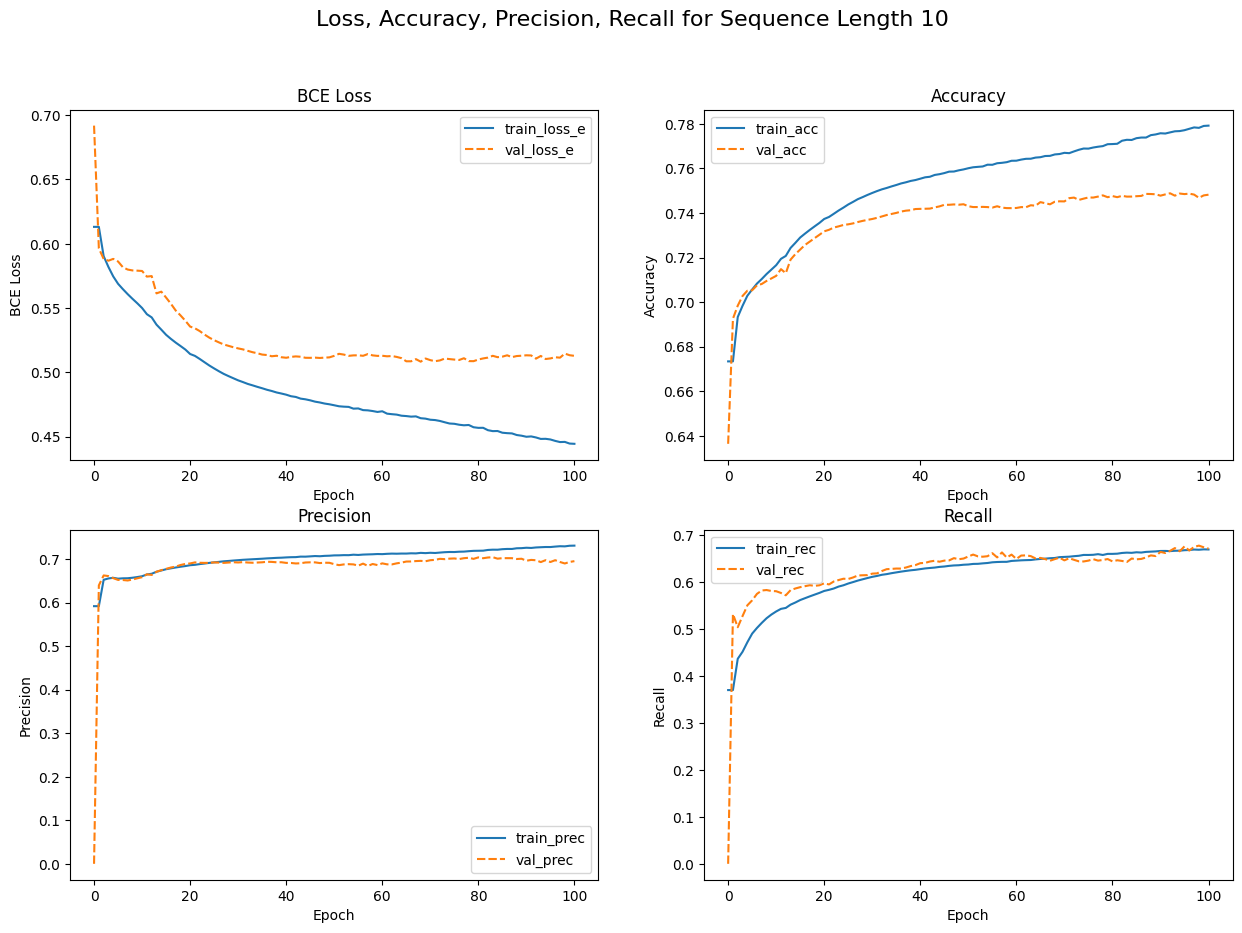

In [3]:
log_dir_seq_10 = 's3://dissertation-data-dmiller/lstm_experiments/results/45/ordinal/sequence_length_10/full/2023_01_30_19_23/version_0'

seq_10 = tensorboard_results(log_dir_seq_10, 'Sequence Length 10')

In [4]:
log_dir_seq_20 = 's3://dissertation-data-dmiller/lstm_experiments/results/45/ordinal/sequence_length_20/full/2023_01_31_08_29/version_0/'

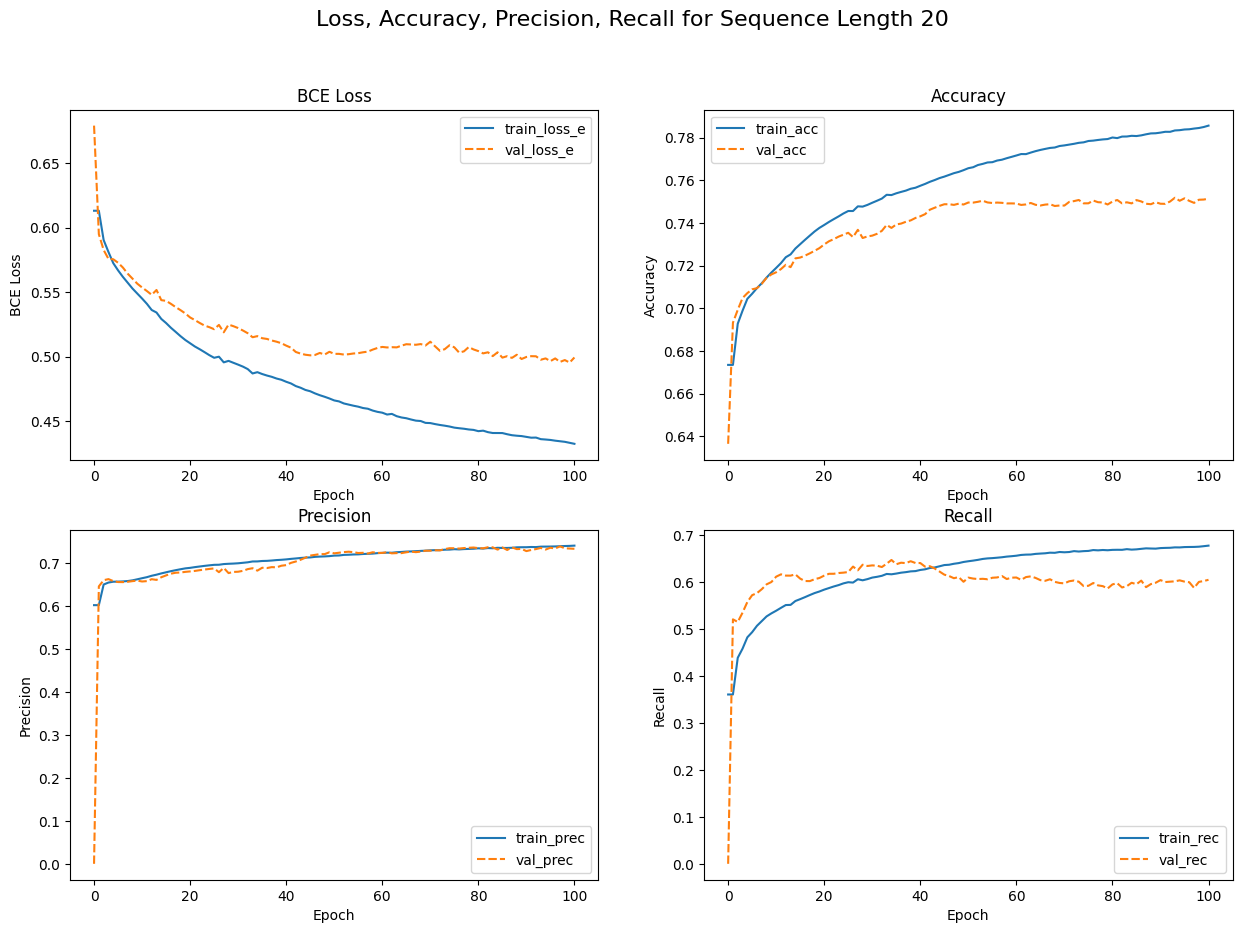

In [5]:
seq_20 = tensorboard_results(log_dir_seq_20, 'Sequence Length 20')

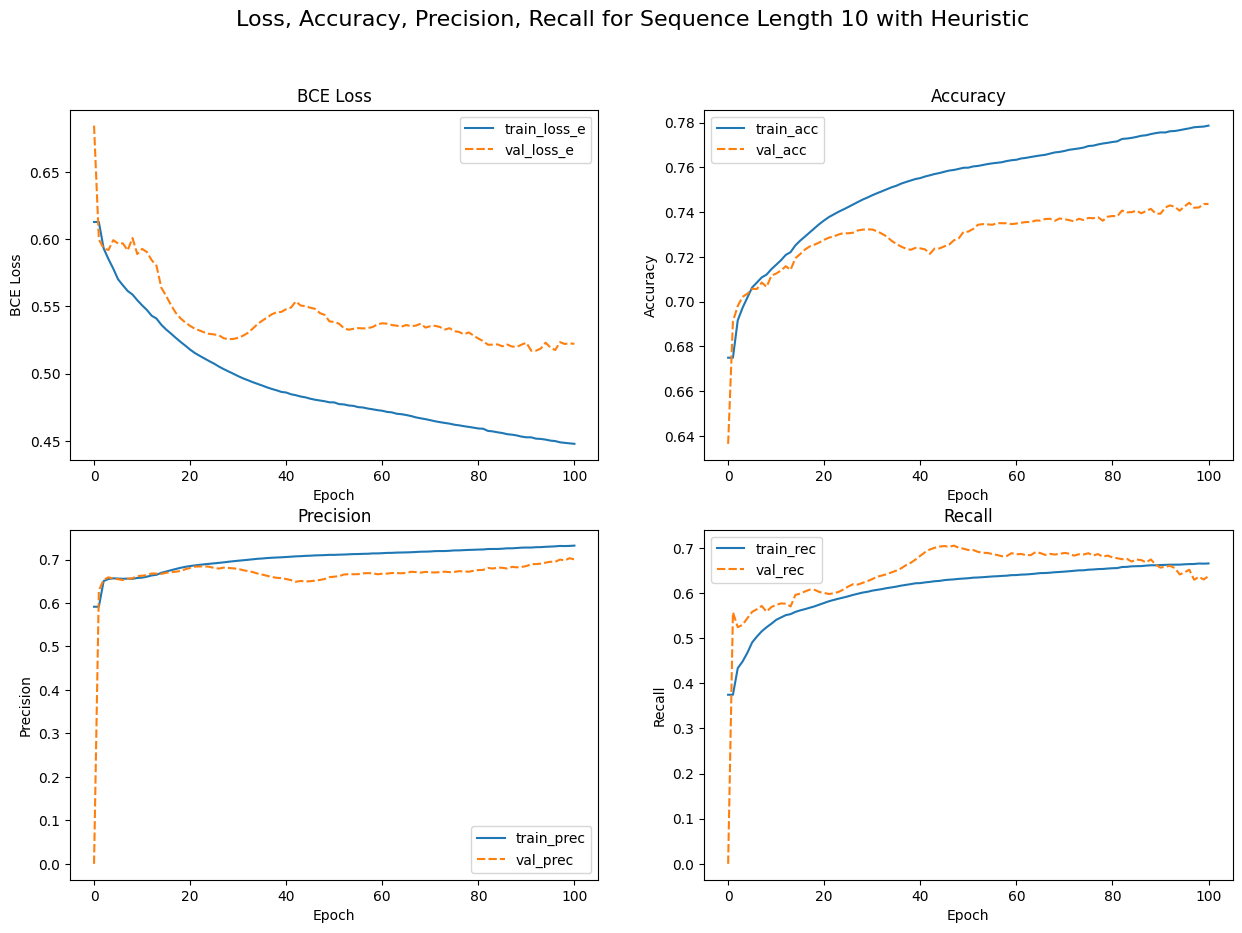

In [6]:
seq_10_results_w_heuristic = 's3://dissertation-data-dmiller/lstm_experiments/results/45/ordinal/sequence_length_10/full/2023_01_31_17_10/version_0'
seq_10_w_heuristic = tensorboard_results(seq_10_results_w_heuristic, 'Sequence Length 10 with Heuristic')

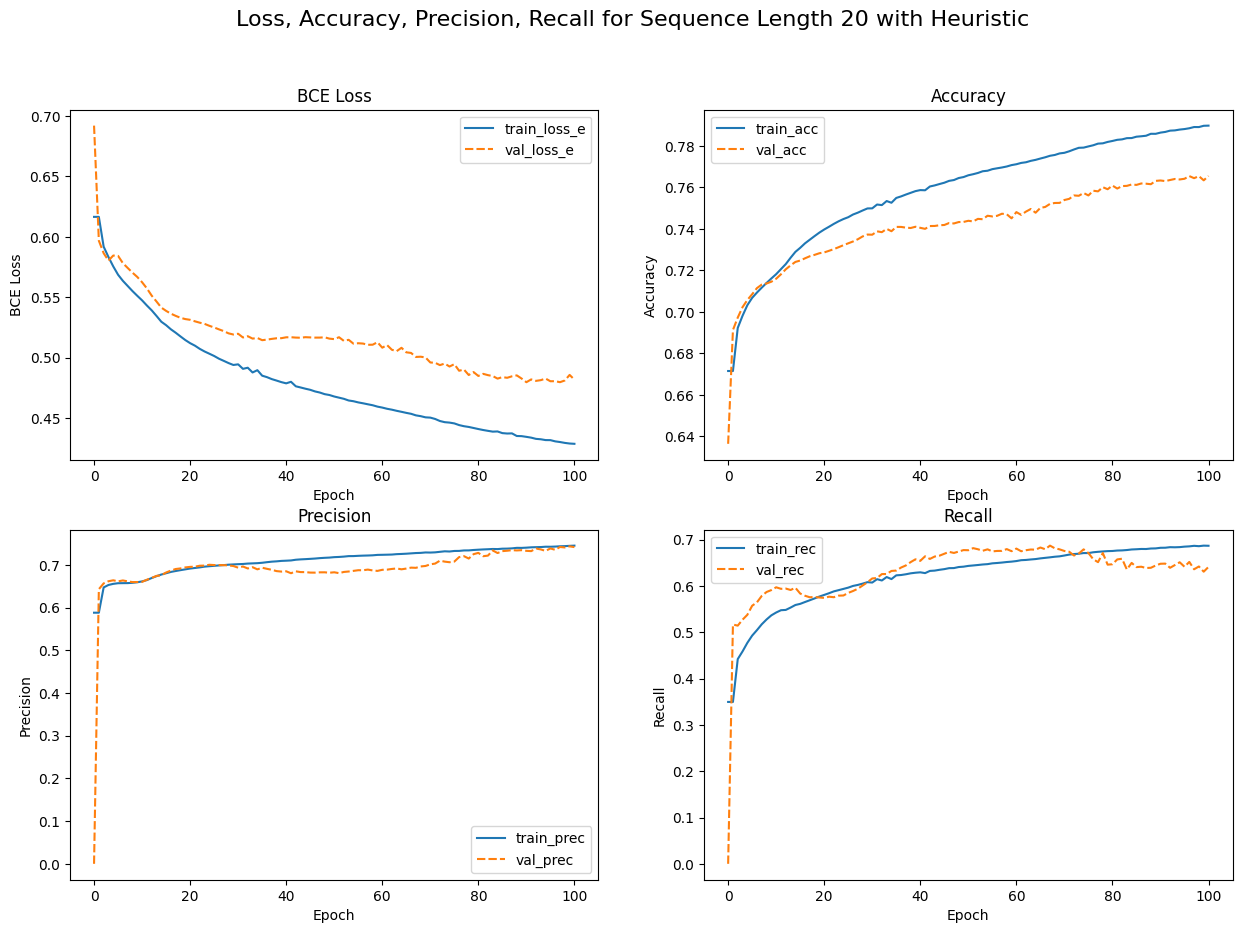

In [7]:
seq_20_w_heuristic = 's3://dissertation-data-dmiller/lstm_experiments/results/45/ordinal/sequence_length_20/full/2023_02_01_22_06/version_0'
seq_20_w_heuristic = tensorboard_results(seq_20_w_heuristic, 'Sequence Length 20 with Heuristic')

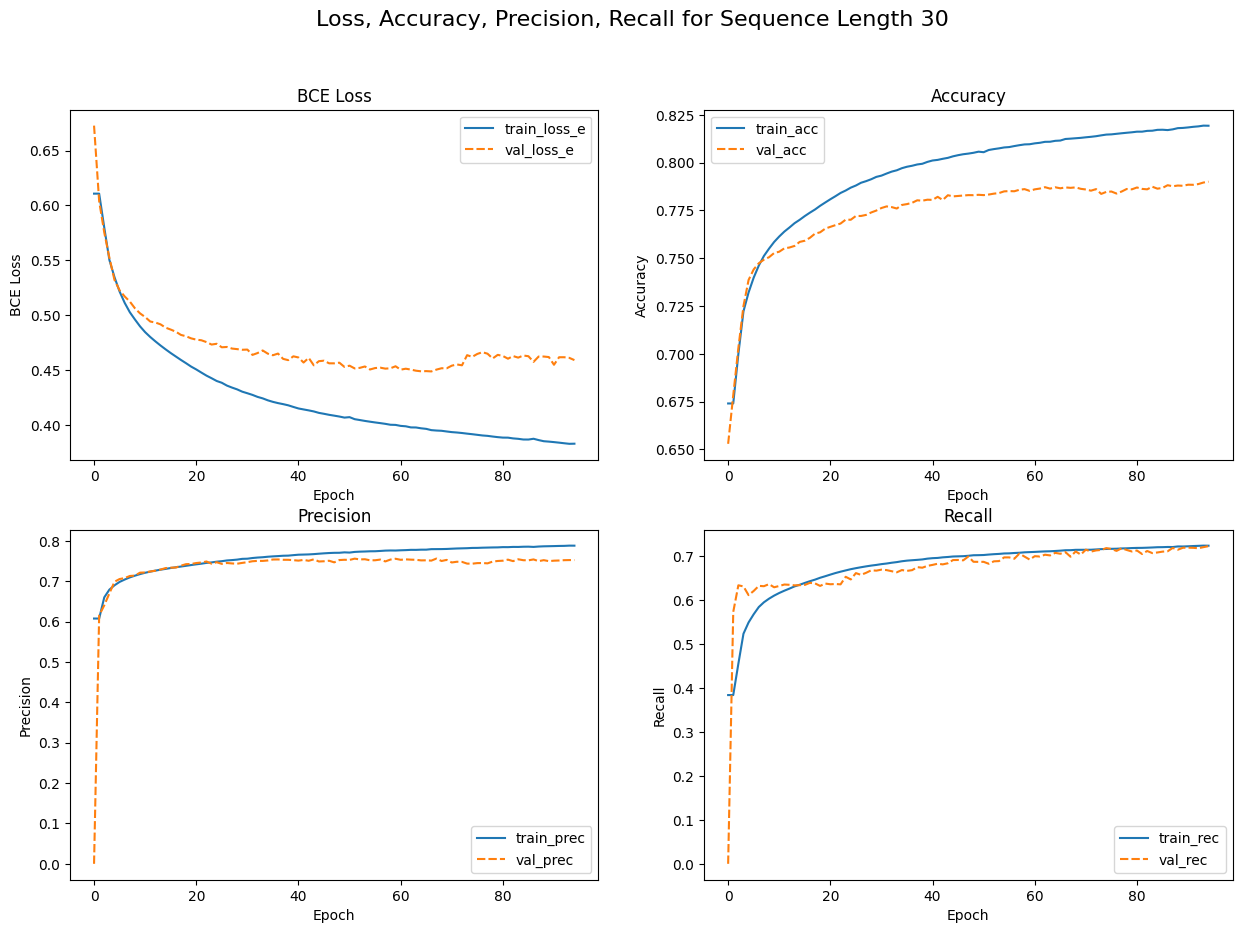

In [8]:
seq_30_results = 's3://dissertation-data-dmiller/lstm_experiments/results/45/ordinal/sequence_length_30/None/2023_02_02_18_41/version_0'
seq_30 = tensorboard_results(seq_30_results, 'Sequence Length 30')

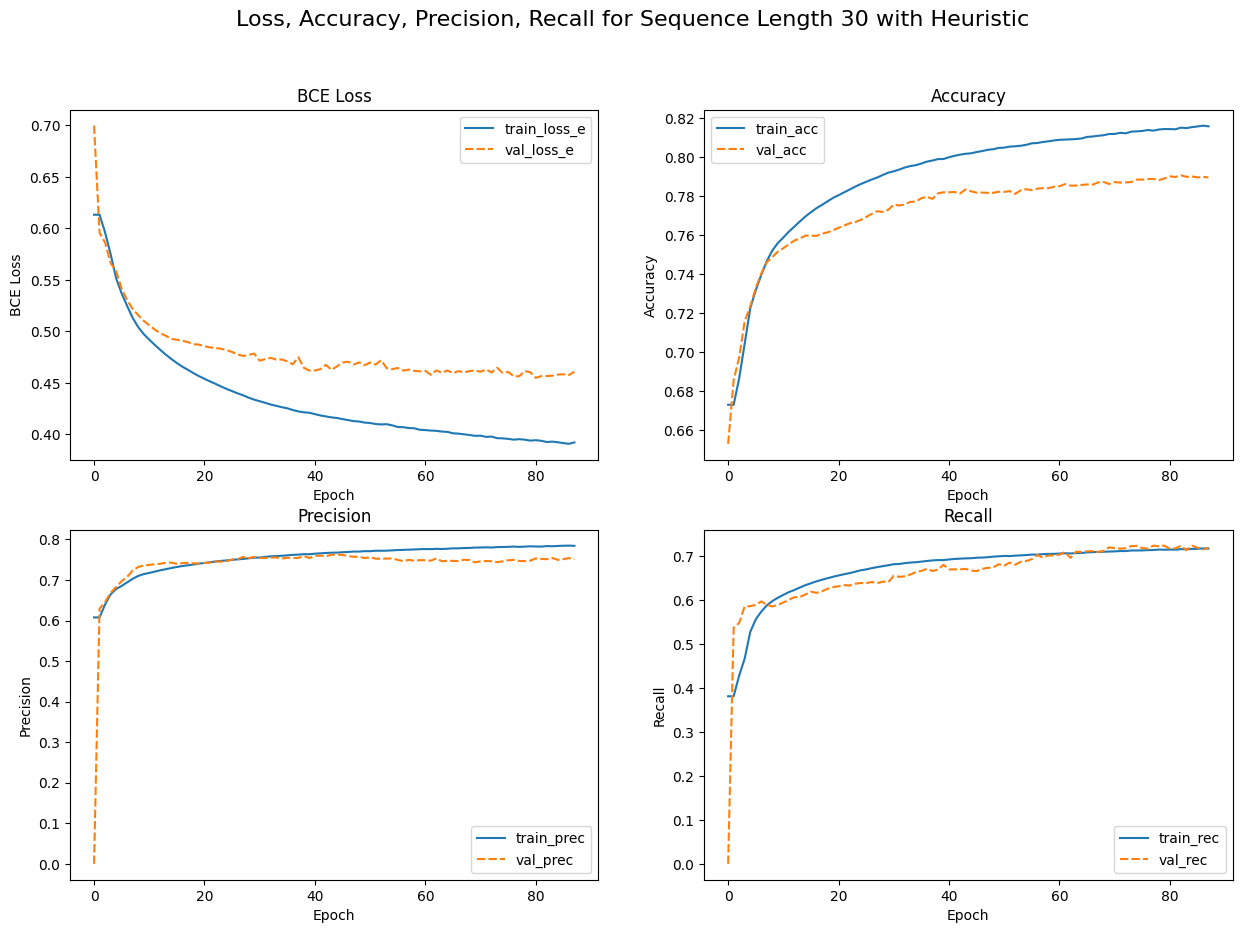

In [9]:
seq_30_w_heuristic = 's3://dissertation-data-dmiller/lstm_experiments/results/45/ordinal/sequence_length_30/None/2023_02_04_13_59/version_0'
seq_30_w_heuristic = tensorboard_results(seq_30_w_heuristic, 'Sequence Length 30 with Heuristic')

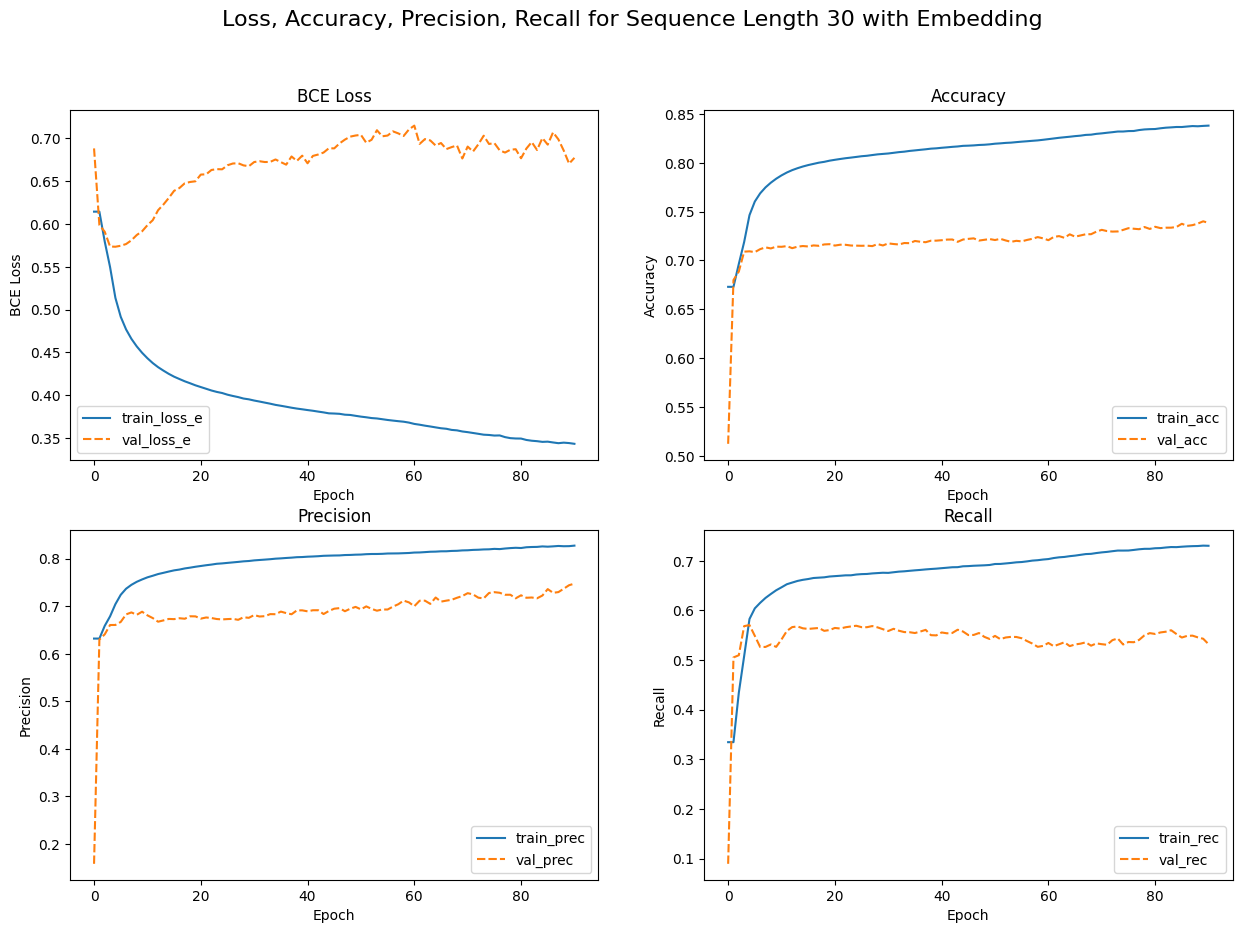

In [10]:
embedding_30 = 's3://dissertation-data-dmiller/lstm_experiments/results/45/embedded/sequence_length_30/None/2023_02_05_19_33/version_0'
embedding_30 = tensorboard_results(embedding_30, 'Sequence Length 30 with Embedding')

In [11]:
metrics = top_metrics(
    {'seq_10_results': seq_10, 
     'seq_20_results': seq_20,
     'seq_30_results': seq_30,
     'embedding_30': embedding_30,
     'seq_10_results_w_heuristic': seq_10_w_heuristic,
     'seq_20_results_w_heuristic': seq_20_w_heuristic,
     'seq_30_results_w_heuristic': seq_30_w_heuristic})

In [12]:
metrics

,Experiment,BCE Loss,Accuracy,Precision,Recall
0,seq_10_results,0.5128,0.7482,0.6953,0.6719
1,seq_20_results,0.4994,0.7514,0.7327,0.6047
2,seq_30_results,0.4591,0.7900,0.7523,0.7233
3,embedding_30,0.6773,0.7384,0.7473,0.5320
4,seq_10_results_w_heuristic,0.5222,0.7436,0.7000,0.6378
5,seq_20_results_w_heuristic,0.4819,0.7656,0.7416,0.6412
6,seq_30_results_w_heuristic,0.4608,0.7894,0.7516,0.7198
